# IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY

## Data Exploration and Cleanup

In [1]:
# import time
# from scipy.stats import linregress

# Incorporated citipy to determine city based on latitude and longitude
# from citipy import citipy

In [2]:
# url = "https://api.openaq.org/v1/measurements"

# data = requests.get(url).json()
# pprint(data)

In [3]:
# len(data["results"])

In [4]:
# data["results"][0]

https://www.weatherbit.io/api/airquality-history#:~:text=Air%20Quality%20API%20(Historical),an%20air%20quality%20index%20score.

aqi: Air Quality Index [US - EPA standard 0 - +500]
o3: Concentration of surface O3 (µg/m³)
so2: Concentration of surface SO2 (µg/m³)
no2: Concentration of surface NO2 (µg/m³)
co: Concentration of carbon monoxide (µg/m³)
pm25: Concentration of particulate matter < 2.5 microns (µg/m³)
pm10: Concentration of particulate matter < 10 microns (µg/m³)

Some good info on air pollution impacts https://ourworldindata.org/air-pollution
https://www.who.int/health-topics/air-pollution#tab=tab_1

https://waqi.info/
The Air Quality Index is based on measurement of particulate matter (PM2.5 and PM10), Ozone (O3), Nitrogen Dioxide (NO2), Sulfur Dioxide (SO2) and Carbon Monoxide (CO) emissions. Most of the stations on the map are monitoring both PM2.5 and PM10 data, but there are few exceptions where only PM10 is available.

All measurements are based on hourly readings: For instance, an AQI reported at 8AM means that the measurement was done from 7AM to 8AM.
More details https://aqicn.org/faq/

https://www.epa.vic.gov.au/for-community/airwatch
https://www.kaggle.com/frtgnn/clean-air-india-s-air-quality/data

In [5]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import openaq
from pprint import pprint

# Import API key
from config import api_key

In [6]:
# Data source: https://aqicn.org/api/
base_url = "https://api.waqi.info/feed/"
city = "melbourne"
url = f"{base_url}{city}/?token={api_key}"

In [7]:
data = requests.get(url).json()
pprint(data)

{'data': {'aqi': 24,
          'attributions': [{'logo': 'Australia-Victoria.png',
                            'name': 'Environment Protection Authority | EPA '
                                    'Victoria',
                            'url': 'http://epa.vic.gov.au/'},
                           {'name': 'World Air Quality Index Project',
                            'url': 'https://waqi.info/'}],
          'city': {'geo': [-37.8073959, 144.97],
                   'name': 'Melbourne CBD',
                   'url': 'https://aqicn.org/city/australia/melbourne/melbourne-cbd'},
          'debug': {'sync': '2020-07-04T05:18:16+09:00'},
          'dominentpol': 'pm25',
          'forecast': {'daily': {'o3': [{'avg': 4,
                                         'day': '2020-07-02',
                                         'max': 11,
                                         'min': 3},
                                        {'avg': 3,
                                         'day': '2020-07-03'

"https://aqicn.org/data-platform/covid19/
With the COVID-19 spreading out all over the world, the World Air Quality Index project team saw a surge in requests for global data covering the whole world map. As a result, the WAQI project is now providing a new dedicated data-set, updated 3 times a day, and covering about 380 major cities in the world, from January 2020 until now.

The data for each major cities is based on the average (median) of several stations. The data set provides min, max, median and standard deviation for each of the air pollutant species (PM2.5,PM10, Ozone ...) as well as meteorological data (Wind, Temperature, ...). All air pollutant species are converted to the US EPA standard (i.e. no raw concentrations). All dates are UTC based. The count column is the number of samples used for calculating the median and standard deviation."

In [8]:
periods = ["2020", "2019Q1", "2019Q2", "2019Q3", "2019Q4", "2018H1", "2017H1", "2016H1", "2015H1"]

"Daily air quality and meteorological measurementa for majors world-wide cities in 2020
By using this data you agree with the terms of service: https://aqicn.org/data-platform/tos/
For more information check: https://aqicn.org/data-platform/covid19/
Data-Set 2020 Generated on 2020-07-03T09:04:30+01:00
Data-Set 2019Q4 Generated on 2020-04-13T01:05:30+01:00
Data-Set 2019Q3 Generated on 2020-04-13T01:05:11+01:00
Data-Set 2019Q2 Generated on 2020-04-13T01:04:56+01:00
Data-Set 2019Q1 Generated on 2020-04-13T01:04:43+01:00
Data-Set 2018H1 Generated on 2020-04-18T02:12:17+01:00
Data-Set 2017H1 Generated on 2020-04-18T02:12:55+01:00
Data-Set 2016H1 Generated on 2020-04-18T01:17:52+01:00
Data-Set 2015H1 Generated on 2020-04-18T02:08:00+01:00"

In [9]:
df_dict = dict()
for period in periods:
    path = f"historical_data/waqi-covid19-airqualitydata-{period}.csv"
    df = pd.read_csv(path)
    df_dict[f"df{period}"] = df

In [10]:
df_dict

{'df2020':                Date Country     City       Specie  count   min   max  median  \
 0        31/05/2020      IR  Isfahan  temperature    120  17.5  35.0    27.5   
 1        13/06/2020      IR  Isfahan  temperature    144  16.0  36.5    27.5   
 2         3/07/2020      IR  Isfahan  temperature     67  19.0  33.0    24.0   
 3        28/03/2020      IR  Isfahan  temperature    240   3.0  14.0     9.5   
 4        23/04/2020      IR  Isfahan  temperature    168   6.0  25.5    16.0   
 ...             ...     ...      ...          ...    ...   ...   ...     ...   
 1048566  26/02/2020      US   Dallas    wind gust     45   0.5  27.2    21.4   
 1048567  16/03/2020      US   Dallas    wind gust     45   1.1  15.1     6.4   
 1048568  21/03/2020      US   Dallas    wind gust     26   2.6  15.1     8.9   
 1048569  27/03/2020      US   Dallas    wind gust     46   6.1  23.5    10.8   
 1048570   6/01/2020      US   Dallas    wind gust     41   0.5  12.9     6.7   
 
          varian

In [11]:
df2020 = df_dict["df2020"]
df2020.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,31/05/2020,IR,Isfahan,temperature,120,17.5,35.0,27.5,331.51
1,13/06/2020,IR,Isfahan,temperature,144,16.0,36.5,27.5,488.74
2,3/07/2020,IR,Isfahan,temperature,67,19.0,33.0,24.0,128.08
3,28/03/2020,IR,Isfahan,temperature,240,3.0,14.0,9.5,136.68
4,23/04/2020,IR,Isfahan,temperature,168,6.0,25.5,16.0,400.79


In [12]:
df2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048571 entries, 0 to 1048570
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Date      1048571 non-null  object 
 1   Country   1048571 non-null  object 
 2   City      1048571 non-null  object 
 3   Specie    1048571 non-null  object 
 4   count     1048571 non-null  int64  
 5   min       1048571 non-null  float64
 6   max       1048571 non-null  float64
 7   median    1048571 non-null  float64
 8   variance  1048571 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 72.0+ MB


We can see that Date column is of a generic object type which could be a string. Since we want to perform time related actions on this data, we need to convert it to a datetime format before it can be useful to us. Let’s cast the Date column to a datetime object instead of a generic object using to_datetime() helper function

In [13]:
df2020["Date"] = pd.to_datetime(df2020["Date"], format="%d/%m/%Y")

In [14]:
df2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048571 entries, 0 to 1048570
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Date      1048571 non-null  datetime64[ns]
 1   Country   1048571 non-null  object        
 2   City      1048571 non-null  object        
 3   Specie    1048571 non-null  object        
 4   count     1048571 non-null  int64         
 5   min       1048571 non-null  float64       
 6   max       1048571 non-null  float64       
 7   median    1048571 non-null  float64       
 8   variance  1048571 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 72.0+ MB


In [15]:
df2020["Country"].unique()

array(['IR', 'TJ', 'BR', 'CN', 'DK', 'ES', 'ML', 'SK', 'XK', 'CL', 'DE',
       'KW', 'MM', 'PH', 'PK', 'PL', 'RU', 'SE', 'SG', 'AE', 'BA', 'CZ',
       'ID', 'IS', 'MO', 'RO', 'AR', 'AU', 'EC', 'GH', 'HK', 'PE', 'UA',
       'EE', 'FR', 'JP', 'MN', 'FI', 'IE', 'IL', 'KZ', 'LA', 'UZ', 'BD',
       'BE', 'GR', 'KR', 'LK', 'MK', 'MX', 'TR', 'AF', 'AT', 'GT', 'BO',
       'CR', 'JO', 'PR', 'SA', 'SV', 'CA', 'IT', 'NO', 'RE', 'TM', 'ZA',
       'BH', 'LT', 'TH', 'BG', 'CH', 'HU', 'MY', 'NL', 'NZ', 'UG', 'VN',
       'ET', 'GE', 'GN', 'IQ', 'RS', 'TW', 'CI', 'CO', 'CY', 'DZ', 'HR',
       'IN', 'KG', 'CW', 'GB', 'NP', 'PT', 'US'], dtype=object)

In [16]:
df2020["Country"].nunique()

95

In [17]:
df2020["City"].unique()

array(['Isfahan', 'Arāk', 'Karaj', 'Qom', 'Orūmīyeh', 'Yazd', 'Īlām',
       'Kerman', 'Khorramshahr', 'Tabriz', 'Bandar Abbas', 'Sanandaj',
       'Kermanshah', 'Khorramabad', 'Shiraz', 'Zanjān', 'Mashhad',
       'Tehran', 'Dushanbe', 'São José dos Campos', 'Vitória',
       'São Paulo', 'Beijing', 'Jieyang', 'Kunming', 'Hangzhou',
       'Chongqing', 'Qingdao', 'Haikou', 'Ürümqi', 'Qiqihar', 'Guiyang',
       'Shenzhen', 'Yunfu', 'Xuchang', 'Yinchuan', 'Shenyang', 'Lhasa',
       'Shanghai', 'Changchun', 'Foshan', 'Nanning', 'Fushun', 'Hefei',
       'Chengdu', 'Hohhot', 'Qinhuangdao', 'Shijiazhuang', 'Shantou',
       'Zhengzhou', 'Nanjing', 'Xining', 'Xi’an', 'Zhuzhou', 'Wuhan',
       'Tianjin', 'Changzhou', 'Nanchang', 'Shiyan', 'Xinxiang', 'Suzhou',
       'Harbin', 'Lanzhou', 'Jinan', 'Changsha', 'Hegang', 'Anyang',
       'Wuxi', 'Taiyuan', 'Guangzhou', 'Fuzhou', 'Ningbo', 'Xiamen',
       'Dongguan', 'Copenhagen', 'Las Palmas de Gran Canaria',
       'Salamanca', 'Barcelona'

In [18]:
df2020["City"].nunique()

594

In [19]:
df2020["Specie"].unique()

array(['temperature', 'wind-speed', 'wind-gust', 'dew', 'pm25',
       'humidity', 'wind speed', 'pressure', 'wind gust', 'co', 'so2',
       'precipitation', 'no2', 'pm10', 'o3', 'aqi', 'pol', 'uvi', 'wd',
       'neph', 'mepaqi', 'pm1'], dtype=object)

In [20]:
df_melbourne_2020 = df2020[df2020["City"]=="Melbourne"]
df_melbourne_2020

,Date,Country,City,Specie,count,min,max,median,variance
358535,2020-06-02,AU,Melbourne,no2,137,2.8,25.1,8.4,432.45
358536,2020-01-22,AU,Melbourne,no2,129,1.9,22.3,7.5,221.55
358537,2020-02-03,AU,Melbourne,no2,180,1.9,13.0,2.8,72.92
358538,2020-03-29,AU,Melbourne,no2,126,1.0,5.6,2.8,14.97
358539,2020-04-22,AU,Melbourne,no2,157,3.8,25.1,9.3,420.75
...,...,...,...,...,...,...,...,...,...
360724,2020-04-08,AU,Melbourne,pm25,225,1.0,85.0,18.0,1417.68
360725,2020-04-17,AU,Melbourne,pm25,226,1.0,40.0,18.0,600.56
360726,2020-05-13,AU,Melbourne,pm25,192,1.0,66.0,20.0,1555.00
360727,2020-06-01,AU,Melbourne,pm25,198,1.0,43.0,10.0,653.08


In [21]:
df_melbourne_2020["Specie"].unique()

array(['no2', 'co', 'wind speed', 'wind-speed', 'so2', 'precipitation',
       'o3', 'dew', 'temperature', 'humidity', 'wind gust', 'pressure',
       'wind-gust', 'pm10', 'pm25'], dtype=object)

In [22]:
df_melbourne_2020_pm25 = df_melbourne_2020[df_melbourne_2020["Specie"]=="pm25"].sort_values("Date")
df_melbourne_2020_pm25

,Date,Country,City,Specie,count,min,max,median,variance
360606,2019-12-30,AU,Melbourne,pm25,81,33.0,59.0,44.0,438.90
360664,2019-12-31,AU,Melbourne,pm25,91,10.0,60.0,43.0,2309.26
360614,2020-01-01,AU,Melbourne,pm25,179,9.0,86.0,28.0,1491.05
360611,2020-01-02,AU,Melbourne,pm25,226,9.0,66.0,27.0,1364.82
360722,2020-01-03,AU,Melbourne,pm25,296,2.0,547.0,71.0,95496.40
...,...,...,...,...,...,...,...,...,...
360618,2020-06-29,AU,Melbourne,pm25,186,4.0,158.0,60.0,9876.10
360548,2020-06-30,AU,Melbourne,pm25,185,1.0,67.0,25.0,2782.67
360564,2020-07-01,AU,Melbourne,pm25,181,2.0,55.0,19.0,1002.37
360700,2020-07-02,AU,Melbourne,pm25,158,1.0,46.0,18.0,858.35


In [23]:
df_melbourne_2020_pm25["Date"]

360606   2019-12-30
360664   2019-12-31
360614   2020-01-01
360611   2020-01-02
360722   2020-01-03
            ...    
360618   2020-06-29
360548   2020-06-30
360564   2020-07-01
360700   2020-07-02
360610   2020-07-03
Name: Date, Length: 187, dtype: datetime64[ns]

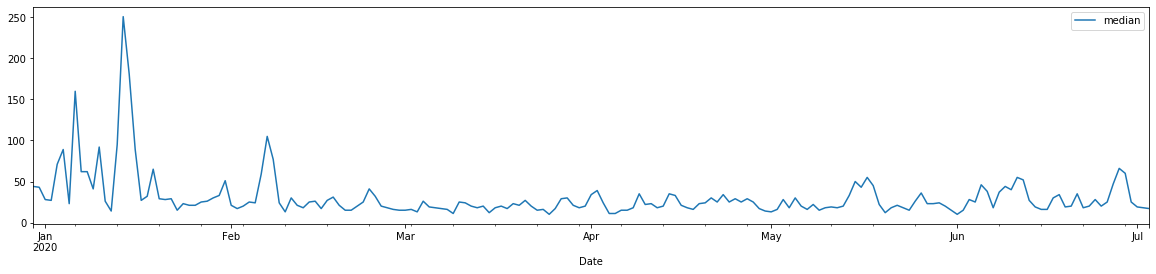

In [27]:
df_melbourne_2020_pm25.plot(x="Date", y="median", figsize=(20, 4))